### reinforce_ff_multiseq_play_3
* RL - Gradient - FeedForward agent
* finishes the episode if reward drops to a value, that is the maximum reward of previous episode, only if it is better than current.
* next episode starts with a random sequence
* next reward for the gradient calculatin is the best reward found so far

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
import time

In [2]:
max_no_of_layers = 6
len_search_space = 382

alpha = 1e-8   # learning rate in the policy gradient
gamma = 0.99  # decay rate of past observations
learning_rate = 1e-3  # learning rate of NN agent

reward_min = 0.55

no_of_episodes = 200  # number of training iterations 
max_plays = 20
min_plays = 5
rollout_n = 1  # number of episodes between policy update

states, gradients, probs, rewards = [], [], [], []

In [3]:
# model_output_shape = (max_no_of_layers-1, len_search_space)
# model = Sequential()
# model.add(Dense(128, input_shape=(max_no_of_layers-1,), activation="relu")) 
# model.add(Dense(128, activation="relu"))  
# model.add(Dense(64, activation="relu")) 
# model.add(Dense(64, activation="relu")) 
# model.add(Dense(32, activation="relu")) 
# model.add(Dense(32, activation="relu")) 
# model.add(Dense(32, activation="relu")) 
# model.add(Dense(32, activation="relu")) 
# model.add(Dense(model_output_shape[0]*model_output_shape[1], activation="softmax")) 
# model.add(Reshape(model_output_shape))
# model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate))

In [4]:
# model_output_shape = (max_no_of_layers-1, len_search_space)
# model = Sequential()
# model.add(Dense(1024, input_shape=(max_no_of_layers-1,), activation="relu")) 
# model.add(Dense(1024, activation="relu"))  
# model.add(Dense(512, activation="relu")) 
# model.add(Dense(512, activation="relu")) 
# model.add(Dense(256, activation="relu")) 
# model.add(Dense(256, activation="relu")) 
# model.add(Dense(512, activation="relu")) 
# model.add(Dense(1024, activation="relu")) 
# model.add(Dense(model_output_shape[0]*model_output_shape[1], activation="softmax")) 
# model.add(Reshape(model_output_shape))
# model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate))

In [5]:
model_output_shape = (max_no_of_layers-1, len_search_space)
model = Sequential()
model.add(Dense(64, input_shape=(max_no_of_layers-1,), activation="relu")) 
model.add(Dense(32, activation="relu"))  
model.add(Dense(16, activation="relu")) 
model.add(Dense(8, activation="relu")) 
model.add(Dense(8, activation="relu")) 
model.add(Dense(16, activation="relu")) 
model.add(Dense(32, activation="relu")) 
model.add(Dense(64, activation="relu")) 
model.add(Dense(model_output_shape[0]*model_output_shape[1], activation="softmax")) 
model.add(Reshape(model_output_shape))
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                5

In [7]:
def plot_distribution(samples, prob, next_):
    fig, axs = plt.subplots(len(next_), figsize=(24, 6))
    for i in range(len(next_)):
        axs[i].axvline(x=next_[i], c="r", alpha=0.5)
        axs[i].plot(range(0, samples), prob[i])
        axs[i].axis('off')    
    plt.show()

In [8]:
acc_model = keras.models.load_model("accuracy_predictor.h5")
def performance_estimate(sequence):
    seq_hot = keras.utils.to_categorical(sequence, num_classes=len_search_space+1)[np.newaxis]
    acc = acc_model.predict(seq_hot)[0][0]
    return round(acc, 3)

In [9]:
def get_action(state):
    actions = []
    distributions = model.predict(state)
    for distribution in distributions[0]:
        distribution /= np.sum(distribution)  
        action = np.random.choice(len_search_space, 1, p=distribution)[0]
        actions.append(int(action))

#     plot_distribution(len_search_space, distributions[0], actions)
    return actions, distributions

In [10]:
def apply_step(init_state, play_count):
    actions, distribution = get_action(init_state)
    reward = performance_estimate(actions)
    
    done = False
    if reward < reward_min and play_count >= min_plays:
        done = True
    if play_count >= max_plays:
        done = True

    return actions, distribution, reward, done

In [11]:
def remember(state, actions, prob, reward):
    encoded_action = np.zeros(model_output_shape, np.float32) 
    for i, action in enumerate(actions):
        encoded_action[i][action] = 1    

    gradients.append(encoded_action - prob)
    states.append(state)
    rewards.append(reward)
    probs.append(prob)
        
def clear_memory():
    states.clear()
    gradients.clear()
    rewards.clear()
    probs.clear()    

In [12]:
def get_discounted_rewards(rewards_in):
    discounted_rewards = []
    cumulative_total_return = 0

    for reward in rewards_in[::-1]:  # iterate the rewards backwards and and calc the total return 
        cumulative_total_return = (cumulative_total_return * gamma) + reward
        discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards = np.mean(discounted_rewards)
    std_rewards = np.std(discounted_rewards)
    norm_discounted_rewards = (discounted_rewards - mean_rewards) / (std_rewards + 1e-7) # avoiding zero div

    return norm_discounted_rewards

In [13]:
def update_policy():
    states_ = np.vstack(states)
    
    gradients_ = np.vstack(gradients)
    rewards_ = np.vstack(rewards)
    discounted_rewards = get_discounted_rewards(rewards_)
    discounted_rewards = discounted_rewards.reshape(discounted_rewards.shape[0], discounted_rewards.shape[1], discounted_rewards.shape[1])
    gradients_ *= discounted_rewards
    probs_ = probs
#     probs_ = np.clip(probs_, 1e-36, 1e36)
    gradients_ = alpha * gradients_ + np.vstack(probs)
    
    history = model.train_on_batch(states_, gradients_)
    clear_memory()
    return history

In [14]:
history_accuracy_per_play = []
history_sequence_per_play = []
history_loss = []
history_sequence_per_episode = []
history_accuracy_per_episode = []
history_avg_accuracy_per_episode = []
history_play_counts = []
history_rewards = []
history_minmax = []
history_bestsofar = []

rew = 0.7

t1 = time.time()
# sequence = np.random.randint(1, len_search_space, max_no_of_layers-1, dtype="int32")[np.newaxis]
sequence = np.zeros(max_no_of_layers-1, dtype="int32")[np.newaxis]
for episode in range(no_of_episodes):
    sequence = np.zeros(max_no_of_layers-1, dtype="int32")[np.newaxis]
#     sequence = np.random.randint(1, len_search_space, max_no_of_layers-1, dtype="int32")[np.newaxis]  # starts the episode with random sequence
    done = False          
    episode_reward = 0  
    play_counter = 0
    episode_acc = []
    episode_seq = []
    while not done:
        play_counter += 1
        actions, prob, reward, done = apply_step(sequence, play_counter)
        history_accuracy_per_play.append(reward)
        remember(sequence, actions, prob, reward)
#         remember(sequence, actions, prob, rew)
        sequence = np.array(actions)[np.newaxis]
        history_sequence_per_play.append(sequence)
        episode_reward += reward
        
        episode_acc.append(reward)
        episode_seq.append(sequence)
        
        if len(episode_acc) >= min_plays and np.var(episode_acc) < 1e-2:
            done = True

        if done:
#             rew = max(episode_acc) + 0.005
            rew = max(history_accuracy_per_play) + 0.01
            reward_avg = np.average(episode_acc)
#             reward_min = reward_avg if reward_avg > reward_min else reward_min  # increases the min_reward to best episode avg 
            history_minmax.append([reward_min, max(episode_acc)])
#             sequence = episode_seq[episode_acc.index(max(episode_acc))]
#             sequence = history_sequence_per_play[history_accuracy_per_play.index(max(history_accuracy_per_play))]
            
            history_sequence_per_episode.append(sequence)
            history_accuracy_per_episode.append(reward)
            history_play_counts.append(play_counter)
            history_bestsofar.append(max(history_accuracy_per_play))
            history_avg_accuracy_per_episode.append(np.average(episode_acc))
            if episode%rollout_n == 0:  
                history = update_policy()
                history_loss.append(history)

    history_rewards.append(episode_reward)
    print("Episode", episode+1, "\t Plays:", play_counter, 
          "\t Max accuracy:", round(max(episode_acc), 3), "\t reward_min:", round(reward_min, 3), "\t Best accuracy:", max(history_accuracy_per_play),
          "\t loss:", history,
         )

print("DONE", int(time.time()-t1), "sec")

Episode 1 	 Plays: 7 	 Max accuracy: 0.817 	 reward_min: 0.55 	 Best accuracy: 0.817 	 loss: 4.678948402404785
Episode 2 	 Plays: 5 	 Max accuracy: 0.807 	 reward_min: 0.55 	 Best accuracy: 0.817 	 loss: 5.1317243576049805
Episode 3 	 Plays: 5 	 Max accuracy: 0.831 	 reward_min: 0.55 	 Best accuracy: 0.831 	 loss: 4.945411682128906
Episode 4 	 Plays: 5 	 Max accuracy: 0.791 	 reward_min: 0.55 	 Best accuracy: 0.831 	 loss: 5.088604927062988
Episode 5 	 Plays: 11 	 Max accuracy: 0.846 	 reward_min: 0.55 	 Best accuracy: 0.846 	 loss: 4.4646806716918945
Episode 6 	 Plays: 5 	 Max accuracy: 0.693 	 reward_min: 0.55 	 Best accuracy: 0.846 	 loss: 4.701193332672119
Episode 7 	 Plays: 5 	 Max accuracy: 0.792 	 reward_min: 0.55 	 Best accuracy: 0.846 	 loss: 4.9684062004089355
Episode 8 	 Plays: 5 	 Max accuracy: 0.796 	 reward_min: 0.55 	 Best accuracy: 0.846 	 loss: 4.792076587677002
Episode 9 	 Plays: 5 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.846 	 loss: 4.6408877372741

Episode 74 	 Plays: 7 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.849345862865448
Episode 75 	 Plays: 9 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.660602331161499
Episode 76 	 Plays: 5 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 1.1890840530395508
Episode 77 	 Plays: 9 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.6606022715568542
Episode 78 	 Plays: 8 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.7431776523590088
Episode 79 	 Plays: 5 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 1.1890840530395508
Episode 80 	 Plays: 5 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 1.1890840530395508
Episode 81 	 Plays: 9 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.660602331161499
Episode 82 	 Plays: 9 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.660

Episode 147 	 Plays: 8 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.7431775331497192
Episode 148 	 Plays: 9 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.6606029272079468
Episode 149 	 Plays: 5 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 1.1891404390335083
Episode 150 	 Plays: 9 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.660602331161499
Episode 151 	 Plays: 8 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.7431775331497192
Episode 152 	 Plays: 5 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 1.1890840530395508
Episode 153 	 Plays: 6 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.9909031987190247
Episode 154 	 Plays: 6 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 loss: 0.9909033179283142
Episode 155 	 Plays: 8 	 Max accuracy: 0.826 	 reward_min: 0.55 	 Best accuracy: 0.851 	 

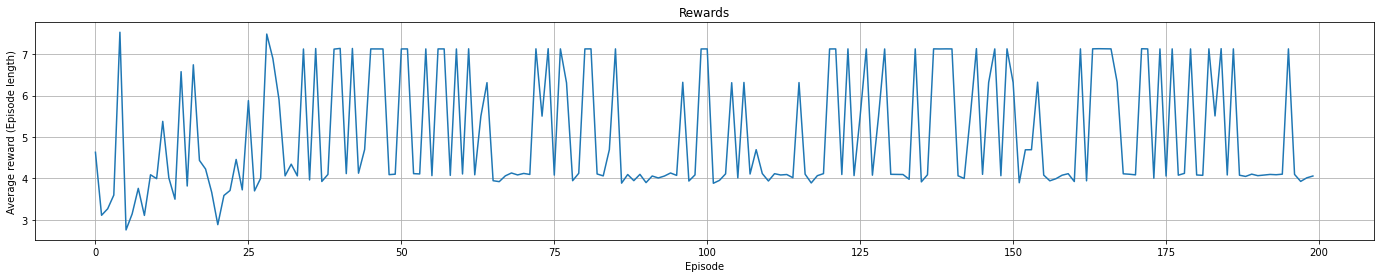

In [15]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_rewards)), history_rewards)
plt.title("Rewards")
plt.xlabel("Episode")
plt.ylabel("Average reward (Episode length)")
plt.grid()
plt.show()

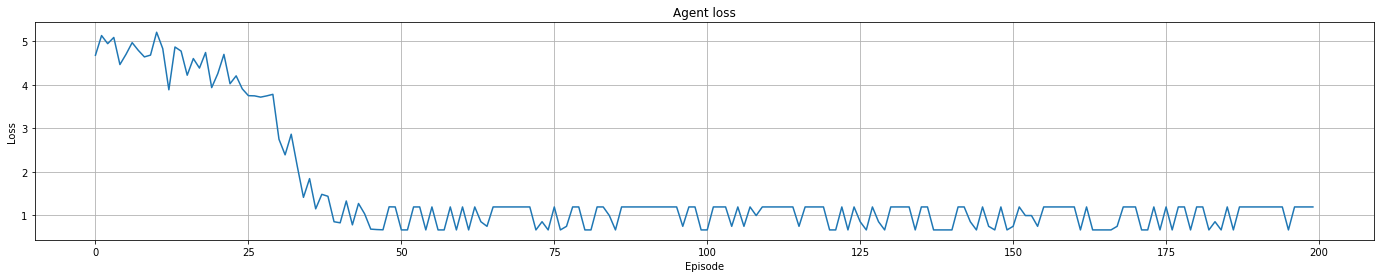

In [16]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_loss)), history_loss)
plt.title("Agent loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
# plt.axhline(y=0, c="k")
plt.grid()
plt.show()

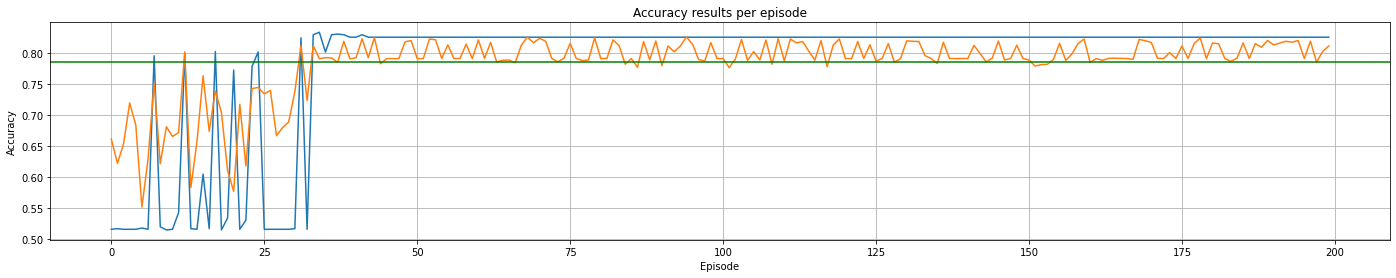

Best accuracy: 0.834
Average accuracy: 0.7854901
Last accuracy: 0.826


In [17]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_accuracy_per_episode)), history_accuracy_per_episode)
plt.plot(np.arange(0,len(history_avg_accuracy_per_episode)), history_avg_accuracy_per_episode)
plt.axhline(y=np.average(history_accuracy_per_episode), c="g")
plt.title("Accuracy results per episode")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.grid()
plt.show()
print("Best accuracy:", max(history_accuracy_per_episode))
print("Average accuracy:", np.average(history_accuracy_per_episode))
print("Last accuracy:", history_accuracy_per_episode[-1])

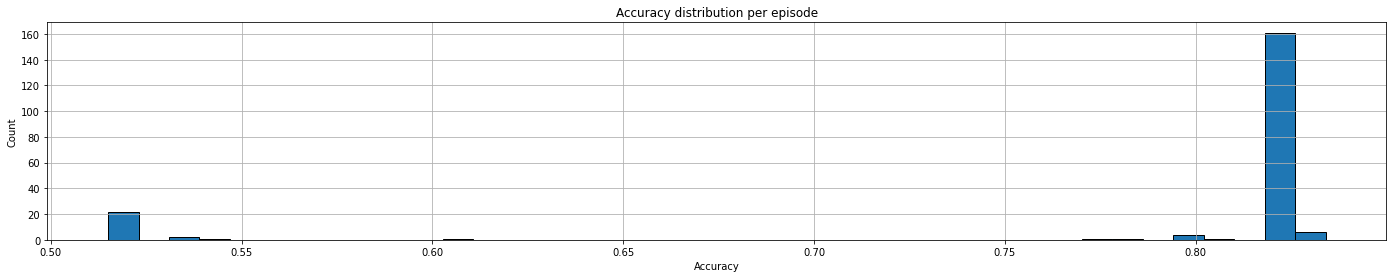

In [18]:
fig = plt.figure(figsize=(24, 4))
bins = int(len(history_accuracy_per_episode)/5)
plt.hist(history_accuracy_per_episode, bins=bins, edgecolor="k")
plt.title("Accuracy distribution per episode")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.grid()
plt.show()

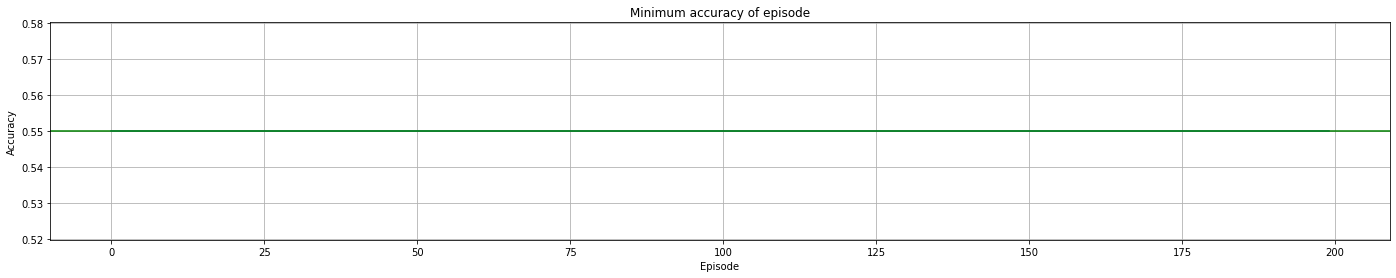

In [19]:
min_acc =  [i[0] for i in history_minmax]
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(min_acc)), min_acc)
plt.axhline(y=np.average(min_acc), c="g")
plt.title("Minimum accuracy of episode")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

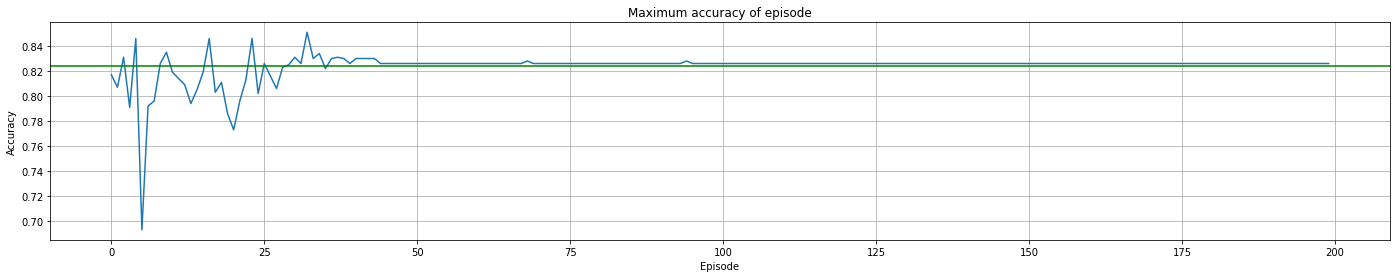

In [20]:
max_acc =  [i[1] for i in history_minmax]
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(max_acc)), max_acc)
plt.axhline(y=np.average(max_acc), c="g")
plt.title("Maximum accuracy of episode")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

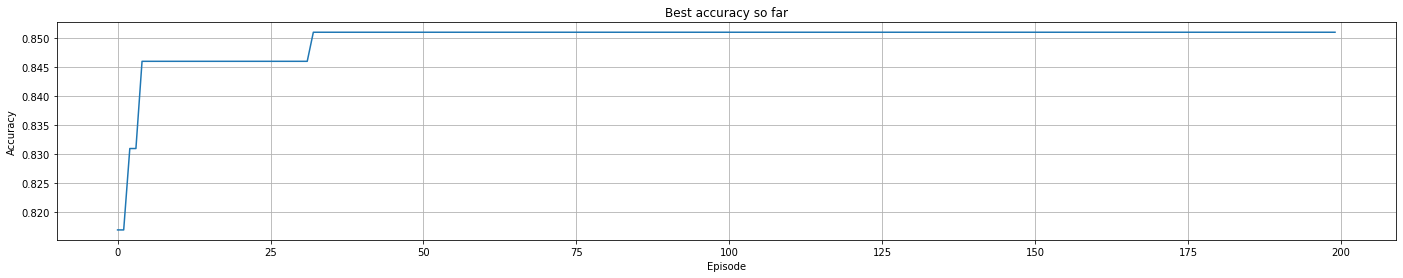

In [21]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_bestsofar)), history_bestsofar)
plt.title("Best accuracy so far")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

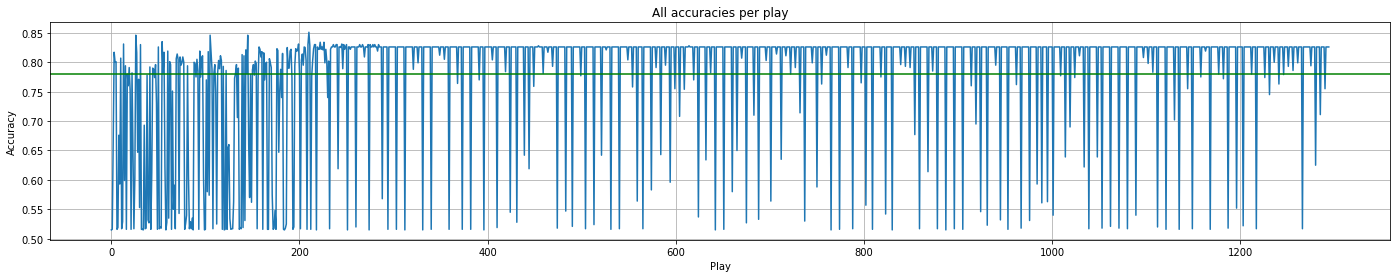

Best accuracy: 0.851
Average accuracy: 0.7805769


In [22]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_accuracy_per_play)), history_accuracy_per_play)
plt.axhline(y=np.average(history_accuracy_per_play), c="g")
plt.title("All accuracies per play")
plt.xlabel("Play")
plt.ylabel("Accuracy")
plt.grid()
plt.show()
print("Best accuracy:", max(history_accuracy_per_play))
print("Average accuracy:", np.average(history_accuracy_per_play))

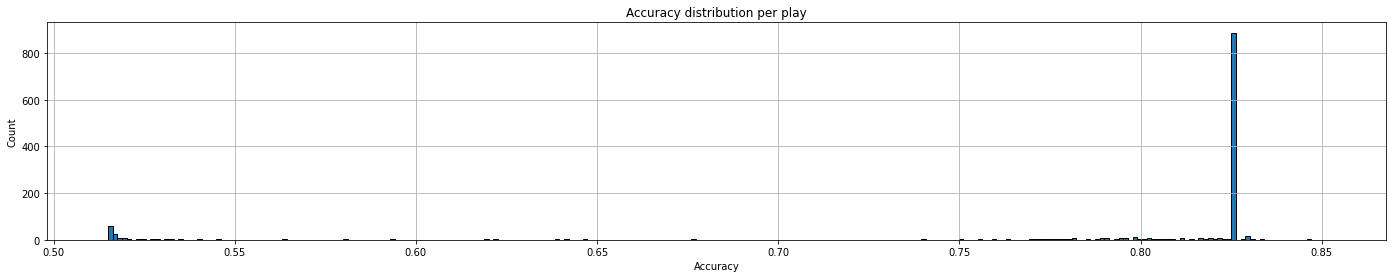

In [23]:
fig = plt.figure(figsize=(24, 4))
bins = int(len(history_accuracy_per_play)/5)
plt.hist(history_accuracy_per_play, bins=bins, edgecolor="k")
plt.title("Accuracy distribution per play")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.grid()
plt.show()

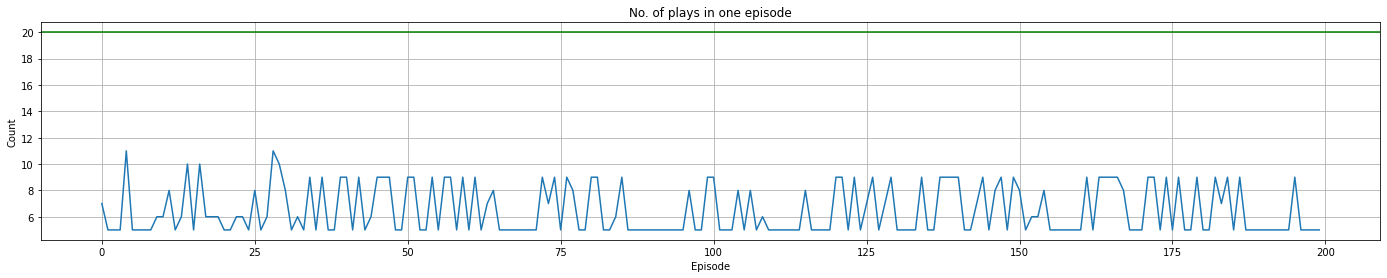

In [24]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_play_counts)), history_play_counts)
plt.axhline(y=max_plays, c="g")
plt.title("No. of plays in one episode")
plt.xlabel("Episode")
plt.ylabel("Count")
plt.grid()
plt.show()

In [25]:
history_sequence_per_episode

[array([[303, 163,  23,  15, 326]]),
 array([[ 79, 281, 141, 278, 361]]),
 array([[ 83, 219, 296, 103,  29]]),
 array([[277, 111, 173, 243,  75]]),
 array([[331, 229, 211, 282, 119]]),
 array([[176, 140, 333, 350,  88]]),
 array([[ 28, 210, 296, 153, 239]]),
 array([[196, 229, 274,  76, 105]]),
 array([[176, 151,  75, 252, 374]]),
 array([[ 73, 229, 263, 157,  42]]),
 array([[ 73, 229, 296, 103,   1]]),
 array([[176,  25, 279,  15, 289]]),
 array([[164, 229, 296, 347, 206]]),
 array([[228, 376, 345, 374, 201]]),
 array([[ 39, 229, 346, 335, 340]]),
 array([[159, 339, 118, 235, 275]]),
 array([[226, 229, 263, 350,  21]]),
 array([[323, 344, 263, 347, 254]]),
 array([[103, 221, 321, 190,  73]]),
 array([[176, 229,  75, 347, 207]]),
 array([[356, 369, 296, 245, 163]]),
 array([[108, 241,  23, 350, 230]]),
 array([[ 28, 357, 118,  71, 258]]),
 array([[343, 214, 118,  71, 155]]),
 array([[165, 229, 310, 347, 105]]),
 array([[217, 289, 118, 370, 346]]),
 array([[217, 229, 296, 328,  91]]),
 

In [26]:
best_sequence = history_sequence_per_play[history_accuracy_per_play.index(max(history_accuracy_per_play))]
print("Best sequence:", best_sequence, "\t with ccuracy:", performance_estimate(best_sequence[0]))
print("Explored:", len(history_sequence_per_play))

Best sequence: [[176 229  86 347 105]] 	 with ccuracy: 0.851
Explored: 1295


* Best sequence: [[226 138 113 369 376]] 	 with ccuracy: 0.892
* Best sequence: [[ 52 174 132  70  89]] 	 with ccuracy: 0.86
* Best sequence: [[358 138 180  71 242]] 	 with ccuracy: 0.883
* Best sequence: [[308  78  48 250 190]] 	 with ccuracy: 0.857
* Best sequence: [[228  74 138  26 177]] 	 with ccuracy: 0.869
* Best sequence: [[ 13  52 240 118  48]] 	 with ccuracy: 0.898
* Best sequence: [[331 153 144 176  82]] 	 with ccuracy: 0.876